# Exercise 06 CNN for Image Classification - Assignment - Solution

<span style="color:red">**The submission deadline of this assignment is 15/04/2024 23:59. In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained CNN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a multi-class image classification model using CNN.

The problem to be solved is to classify RGB images into one of the 10 pre-defined classes:

![](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a CNN-based image classifier
- Train the network, save and reload the best one
- Test and evaluation

### Import libraries

In [1]:
# [TBC] complete your code here with proper comments
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
# [TBC] complete your code here with proper comments
# suppress all warnings
warnings.filterwarnings("ignore")

## Task 1. Build the data pipeline

You are required to use the PyTorch built-in CIFAR10 dataset, consists of 60,000 $32\times32$ RGB images in 10 classes, with 6,000 images per class. You can find more information about this dataset from the [PyTorch documentation](https://www.tensorflow.org/datasets/catalog/cifar10) and the [original source](https://www.cs.toronto.edu/~kriz/cifar.html).

<span style="color:red">**[TBC]**</span> You need to:
- Use `torchvision.datasets.CIFAR10()` to load the CIFAR10 dataset
- Divide the dataset into the training, valiation, and test set
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [3]:
# [TBC] complete your code here with proper comments
# load CIFAR-10 dataset
train_val_ds = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
test_ds = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2]
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# [TBC] complete your code here with proper comments
# create the train and test data loaders
batch_size = 8192 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

The label of this image is: dog


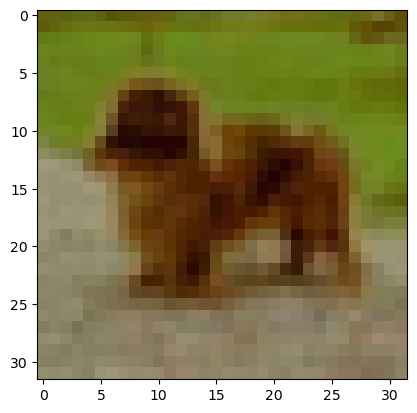

In [16]:
# [TBC] complete your code here with proper comments
# display an example
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.imshow(train_ds[0][0].numpy().transpose(1, 2, 0))
print('The label of this image is:', classes[train_ds[0][1]])

## Task 2. Create a CNN-based image classifier

<span style="color:red">**[TBC]**</span> You need to:
- Define a custom class to specify the structure of the network
    - You are required to use at least one convolutional layer in the network
- Specify the device used for computation
- Create an instance of the network and move it to the corresponding device

In [6]:
# [TBC] complete your code here with proper comments
# define a custom neural network class
class ImageClassifier(nn.Module):
    def __init__(self, in_channels, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 9, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 27, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.Flatten(),
            nn.LazyLinear(1000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
            nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
            nn.LazyLinear(10)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
# [TBC] complete your code here with proper comments
# get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [8]:
# [TBC] complete your code here with proper comments
# create the neural network
cifar_10_model = ImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
).to(device)

## Task 3. Train the network, save and reload the best one

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
    - Embed automatic model saving in the training process
    - <span style="color:red">**Don't forget to include the saved file in your submission.**</span>
- Train the network
    - Adjust the training hyper-parameters if necessary to get a good result
- Reload the best model after training
- Plot the loss history of the training process

In [9]:
# [TBC] complete your code here with proper comments
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss, patience_counter = np.inf, 0
    saved_path, start_time = '', datetime.datetime.now()
    histories = {'train_batch': [], 'train_epoch': [], 'val_batch': [], 'val_epoch': []}

    for epoch in range(epochs):
        # train
        model.train()
        train_epoch_loss = 0.0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            train_batch_loss = loss_fn(model(X), y)
            train_batch_loss.backward()
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
            histories['train_batch'].append(train_batch_loss.item())
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device)
                val_batch_loss = loss_fn(model(X), y)
                val_epoch_loss += val_batch_loss.item()
                histories['val_batch'].append(val_batch_loss.item())
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        if current_lr != optimizer.param_groups[0]['lr']:
            print(f'Learning rate reduced after epoch {epoch+1}')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss, patience_counter = val_epoch_loss, 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = end_time.strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = f'epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping!')
                break
                
    return histories, saved_path

In [10]:
# [TBC] complete your code here with proper comments
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    cifar_10_model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 10
)

In [11]:
# [TBC] complete your code here with proper comments
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    cifar_10_model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
cifar_10_model.load_state_dict(torch.load(saved_path))

Epoch 1: train loss = 2.859061, val loss = 158.968887, time consumed = 0:00:04
Model saved after epoch 1
Epoch 2: train loss = 2.308731, val loss = 15.594210, time consumed = 0:00:06
Model saved after epoch 2
Epoch 3: train loss = 2.212097, val loss = 3.200036, time consumed = 0:00:08
Model saved after epoch 3
Epoch 4: train loss = 2.149504, val loss = 2.287549, time consumed = 0:00:10
Model saved after epoch 4
Epoch 5: train loss = 2.084253, val loss = 2.160551, time consumed = 0:00:12
Model saved after epoch 5
Epoch 6: train loss = 2.018496, val loss = 2.342367, time consumed = 0:00:14
Epoch 7: train loss = 1.946984, val loss = 2.535865, time consumed = 0:00:16
Epoch 8: train loss = 1.897088, val loss = 3.313349, time consumed = 0:00:18
Epoch 9: train loss = 1.847501, val loss = 2.847108, time consumed = 0:00:20
Epoch 10: train loss = 1.821473, val loss = 1.970591, time consumed = 0:00:21
Model saved after epoch 10
Epoch 11: train loss = 1.783423, val loss = 1.792415, time consumed =

<All keys matched successfully>

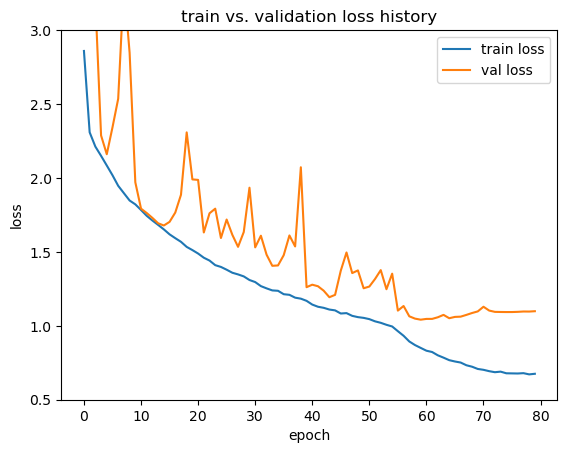

In [12]:
# [TBC] complete your code here with proper comments
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim([0.5, 3])
plt.show()

## Task 4. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [13]:
# [TBC] complete your code here with proper comments
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [14]:
# [TBC] complete your code here with proper comments
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, cifar_10_model, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred, target_names = classes))

test loss = 1.059011995792389
              precision    recall  f1-score   support

       plane       0.70      0.73      0.72      1000
         car       0.81      0.79      0.80      1000
        bird       0.60      0.45      0.51      1000
         cat       0.41      0.50      0.45      1000
        deer       0.54      0.65      0.59      1000
         dog       0.57      0.44      0.50      1000
        frog       0.64      0.75      0.69      1000
       horse       0.76      0.66      0.70      1000
        ship       0.80      0.78      0.79      1000
       truck       0.72      0.76      0.74      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



The predicted class is: plane
The predicted probability is: 0.3863005


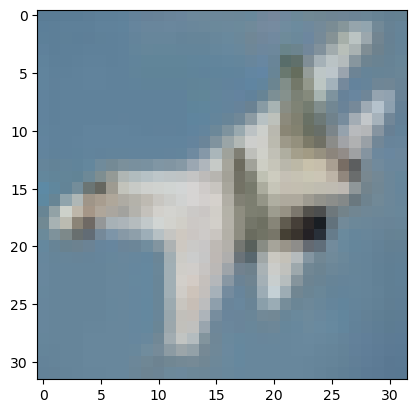

In [15]:
# [TBC] complete your code here with proper comments
# display an example
plt.imshow(test_ds[10][0].numpy().transpose(1, 2, 0))
print('The predicted class is:', classes[test_pred[10]])
print('The predicted probability is:', test_prob[10, test_pred[10]])